# Практическая работа по лекции 12
## Погружение в глубокое обучение
### Преамбула
Сегодня попробуем построить свои первые модели глубоких нейронных сетей. В этой практической работе основной целью будет не работа с данными, а изучение возможностей библиотеки `torch` для построения и обучения моделей и самих методик обучения нейронных сетей.

Практическая работа состоит из двух частей. В первой вы построите последовательную полносвязную модель глубокой сети для распознавания изображений, а во второй $-$ обучите нелинейную архитектуру `Wide&Deep` для создания рекомендательной системы, а заодно и узнаете о принципах её работы.

Сегодня потребуется графический процессор, поэтому работу рекомендуется выполнять в [Google Collab](https://colab.research.google.com/)

### Немного о PyTorch
`PyTorch` — современная библиотека глубокого обучения, развивающаяся под крылом Facebook. Она не похожа на другие популярные библиотеки, такие как `Caffe`, `Theano` и `TensorFlow`. Она позволяет исследователям воплощать в жизнь свои самые смелые фантазии, а инженерам с лёгкостью эти фантазии имплементировать.

`PyTorch` немного похож на `numpy`: он тоже использует в своей основе массивы, которые называются `тензорами`. По сути, тензоры $-$ то же самое, что и `numpy.ndarray`, просто другой тип данных. Однако большинство операций, доступных для работы с тензорами, одинаково или почти похоже называются и в `pytorch`, и в `numpy`.

Почему же тогда исследователи и мы вслед за ними используем для нейронных сетей именно `torch`, а не `numpy`. В отличие от второго, `torch` позволяет запускать сложные матричные вычисления, лежащие в основе всех нейронных сетей, на графическом процессоре, а также легко считает градиенты.

Почему нужен графический процессор (`GPU`), а не обычный процессор? Дело в том, что матричные вычисления, кроме как в нейронных сетях, используются и в графике компьютерных игр. Чтобы игры работали быстрее, нужны эффективные способы считать матрицы и <del>прямые руки программистов</del> мощные видеокарты, которые эти вычисления обеспечивают. Развитие игровой индустрии привело к развитию графических процессоров, за что мы, исследователи искусственного интеллекта, горячо благодарны всем геймерам мира.

Посмотрим, как использовать библиотеку по её прямому назначению. Здесь можете ознакомиться с [документацией](https://pytorch.org/docs/stable/).

### Использование видеокарты в Collab
Откройте Collab и создайте рабочую тетрадку. Затем в верхней панели действий выберите `Среда выполнения`:
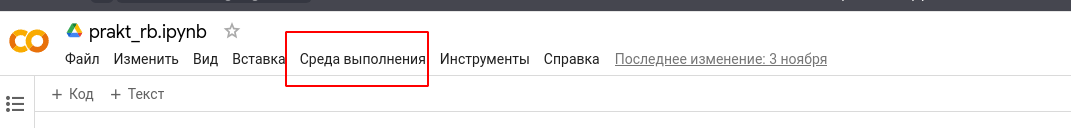
В открывшемся выпадающем меню выберите пункт `Сменить среду выполнения`:
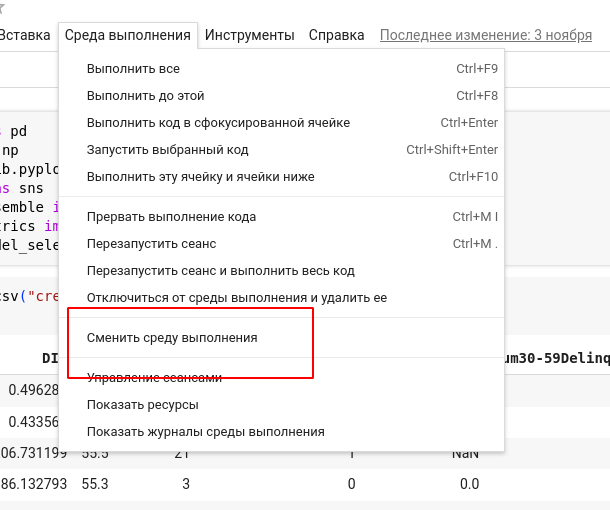
В появившемся окне выберите `T4 GPU` и подтвердите действия. 
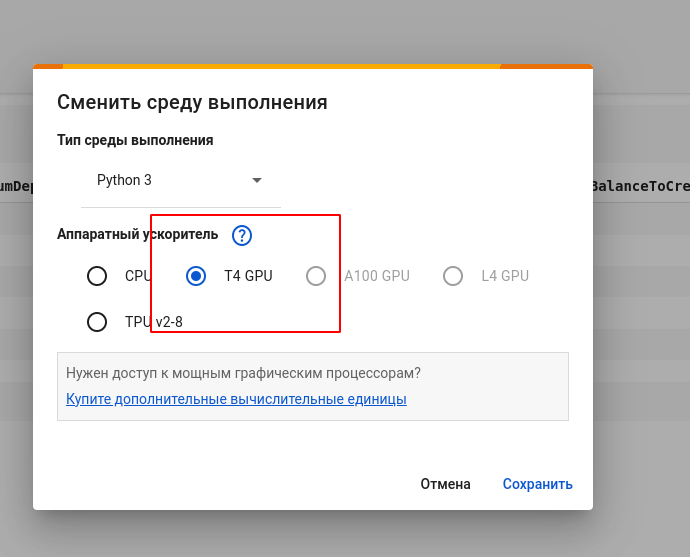
Замечательно! Теперь вам доступна видеокарта с объёмом в 15 ГБ.

## Часть 1. Собираем свою первую нейросеть
### Получение данных
Будем снова распознавать цифры, но в этот раз набор посложнее: больше шума, цифры не центрированы относительно изображения, а сами картинки вообще цветные.

Возьмите файл `download_data.sh` и запустите его командой `! sh download_data.sh`. Это запустит загрузку данных. Когда ячейка отработает, рядом с вашей тетрадкой появится директория `data`, в которой находятся два файла с данным $-$ `train_32x32.mat` и `test_32x32.mat`. Сегодня нас не интересуют сами данные, поэтому они уже собраны и подготовлены Стенфордским университетом. Берите и пользуйтесь.

In [ ]:
# ваш код

### Загрузка данных
Загрузите данные, используя модуль `torchvision.datasets` и его функцию `SVHN`. Для этого укажите для параметра `root` путь к директории с файлами данных, для параметра `split` $-$ одну из трёх строк в заисимости от того, какой набор загружаете: `train`, `test`, `extra`. И для параметра `transform` используйте следующий код:
```
transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
```
Это позволит загрузить данные в виде нормализованного массива `torch.Tensor`.

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms

data_train = # инициализируйте, загрузив данные из train_32x32.mat
data_test = # инициализируйте, загрузив данные из test_32x32.mat

Теперь мы разделим данные на обучающую и валидационную выборки с использованием специальных классов `SubsetRandomSampler` и `DataLoader`. Да, у нас уже есть тестовый набор. Но мы должны его отложить и использовать только для обученной сети. Саму же тренировочную выборку разделим на то, чем будем обучать сеть, и на то, чем её будем тестировать в процессе обучения.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время обучения и группирует их в батчи (мини-пакеты). Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Вам нужно использовать это, чтобы разделить данные на трейн и вал.

Вам нужно указать размер пакета (параметр `batch_size` у `DataLoader`). Обычно размер пакета указывают в виде степени двойки (1, 2, 4, 8, 16, 32, 64, 128 и т.д. образцов). Эта практика идёт от самых первых исследователей, которые полагали, что если компьютер работает на двоичной системе, то ему будет так проще учиться. Однако эмпирически доказано, что в этом нет никакого смысла.

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

batch_size = # укажите размер батча 

# получите индексы экземпляров в data_train (через атрибут data)
# затем перемешайте их случайным образом
# и разделите на два набора в соотношении 8:2

train_sampler = # инициализируйте SubsetRandomSampler для трейна
val_sampler =  # инициализируйте SubsetRandomSampler для валидации

train_loader = # инициализируйте DataLoader
val_loader = # инициализируйте DataLoader

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами (вспомните `MNIST`). Чтобы подавать на вход сети одномерный массив, напишите простой вспомогательный класс `Flattener`.

Объектно-ориентированное программирование в python похоже на ООП в java. Я буду комментировать отличительные моменты, но в основном вы сможете сами всё понять. 

In [ ]:
# запустив этот код, вы сможете убедиться, что имеем дело с трёхмерным массивом
# об этом нам говорит первое измерение, которое равно 3,
# что значит, что перед нами изображение в кодировке из трёх цветов rgb,
# а 32 и 32 говорят, что изображение представляет собой квадратный массив
# формой 32 на 32 пикселя
sample, label = data_train[0]
print("Форма образца: ", sample.shape)

In [ ]:
# словом class начинается объявление класса

# наследование здесь выглядит не так, как в java:
# вместо ключевого слова extends мы указываем родительский класс в скобках
# рядом с названием дочернего

# слово self заменяет this, указывается первым аргументом
# в каждом методе класса
# и передаёт состояние объекта

# реализуйте метод прямого прохода по сети для этого слоя
# он будет выпрямлять тензор x по каждому цвету,
# то есть должен приводить к форме (3, 32*32)

# Module - родительский класс для всех классов,
# которые представляют слои в сети

from torch import nn

class Flattener(nn.Module):
    def forward(self, x):
        pass

### Создание модели
Необходимо создать саму модель, выбрать функцию потерь и определиться с оптимизатором.

Для того, чтобы создать модель, используйте интерфейс `nn.Subclass` ([документация к нему](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)). Он позволяет создавать последовательную стопку словёв, которые связываются между собой. Загляните в документацию модуля [torch.nn](https://pytorch.org/docs/stable/nn.html). Вам нужно найти класс `nn.Linear`, который отвечает за полносвязный слой, и посмотреть, какие параметры инициализации у него есть. 

После этого посмотрите классы, которые отвечают за функции активации. Эти классы-слои указываются сразу после полносвязных слоёв.

Выберите класс, который отвечает за функцию потерь. Подумайте, какую задачу вы решаете. Исходя из этого, выберите функцию потерь.

Загляните в [документацию модуля `torch.optim`](https://pytorch.org/docs/stable/optim.html) и выберите оптимизатор сети на своё усмотрение.

In [ ]:
import torch.optim as optim

nn_model = nn.Sequential(
    # здесь укажите объект класса Flattener, он выпрямит в одномерный вектор картинку,
    # nn.Linear() - сколько нейронов нужно указать в этом слое на входе, а сколько на выходе?
    # здесь укажите слой для функции активации, которую выбрали
    # снова добавьте nn.Linear() - сколько нейронов на входе и на выходе?
)

nn_model.type(torch.FloatTensor)

loss = # здесь инициализируйте функцию потерь
optimizer = # здесь инициализируйте выбранный оптимизатор

### Обучение нейронной сети
Пришло время обучить собранную модель. Вам необходимо дописать функцию `train_model`, чтобы можно было получать показатели модели прямо во время обучения модели.

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = [] # в этот список сохраняем результат ошибки модели, получаемой после прямого прохода по сети
    train_history = [] # сюда сохраняем результат ключевой метрики - accuracy на трейне
    val_history = []  # сюда сохраняем результат accuracy на валидационной выборке
    for epoch in range(num_epochs):
      # одна эпоха - один полный цикл обучения модели на всех данных в наборе
      # во время одной эпохи:
      # !!!!модель учится - вызовите метод train у вашей модели!!!
        loss_accum = 0 # суммируем все ошибки по всем батчам во время одной эпохи
        correct_samples = 0 # считаем, сколько картинок было правильно распознано
        total_samples = 0 # всего образцов в этой эпохе
        for i_step, (x, y) in enumerate(train_loader):
        # идём по пакетам с данными, в каждом пакете batch_size образцов
            prediction = model(x) # вырабатываем прогнозы для образцов в батче во время прямого прохода по сети
            loss_value = # !!!!здесь нужно дописать строку, чтобы посчитать ошибку для этого батча!!!
            optimizer.zero_grad() # перед началом обратного прохода явно зануляем градиенты для батча
            loss_value.backward() # обратный проход по сети
            optimizer.step() # делаем шаг оптимизации

            _, indices = torch.max(prediction, 1) # получаем метки классов с наибольшей вероятностью
            # !!!посчитайте, сколько образцов было правильно распознано в этом батче
            # затем добавьте их ко всем correct_samples!!!
            total_samples += y.shape[0]
            # приплюсуйте ошибку на образцах этого пакета к общей ошибке за всю эпоху

        # !!!посчитайте среднюю accuracy для этой эпохи!!!
        #!!!!посчитайте accuracy на трейне, исходя из того, что у вас есть общее количество правильно распознанных образцов
        # и общее количество образцов, использованных в этой эпохе!!!
        val_accuracy = compute_accuracy(model, val_loader) # считаем accuracy на проверочной выборке

        # сохраните среднюю accuracy, accuracy на трейне и val_accuracy
        print(f"Average loss: {ave_loss}, Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}")
    return loss_history, train_history, val_history

# ниже приведена функция для расчёта accuracy на проверочном наборе
def compute_accuracy(model, loader):
    """
    Рассчитывает accuracy на датасете, переданном в loader

    Возвращает: accuracy в формате float от 0 до 1
    """
    model.eval() # режим выработки прогноза
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)    
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

### Дополнительная оптимизация
Попробуйте самостоятельно поиграть с параметрами и архитектурой этой сети. Добавьте ещё слоёв (но не слишком много), добавьте слои с пакетной нормализацией.

Можно попробовать добавить уменьшение скорости обучения по ходу тренировки. Для этого используется класс [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html). Чтобы его применить, в функции `train_model` придётся добавить ещё один параметр, а вызывать его метод `step()` в самом конце обучения одной эпохи.

В конце замерьте `accuracy` на отложенном тестовом наборе. Если сделали всё верно и смогли правильно настроить, то увидите правильность модели не менее 84%.

In [ ]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

## Часть 2. Построение непоследовательной архитектуры Wide&Deep для системы рекомендаций фильмов

`Рекомендательная система` $-$ это специальный алгоритм, который пытается предсказать, какие объекты (фильмы, кино, музыка и т.д.) будут интересны пользователю на основе данных его профиля. 

При построении таких алгоритмов обычно следуют одной из двух стратегий: или используютколлаборативную фильтрацию, или применяют фильтрацию на основе содержания. 

При `фильтрации на основе содержания` создаются профили пользователей и объектов, профили пользователей могут включать демографическую информацию или ответы на определённый набор вопросов, профили объектов могут включать названия жанров, имена актёров, имена исполнителей и другую атрибутивную информацию в зависимости от типа объекта.

При `коллаборативной фильтрации` используется информация о поведении пользователей в прошлом — например, информация о покупках или оценках. В этом случае не имеет значения, с какими типами объектов ведётся работа, но при этом могут учитываться неявные характеристики, которые сложно было бы учесть при создании профиля. Основная проблема этого типа рекомендательных систем — «холодный старт»: отсутствие данных о недавно появившихся в системе пользователях или объектах.

Однако в ряде случаев можно использовать смешанную стратегию. Как раз этим вы сегодня и займётесь. Ваша задача достроить пайплайн обучения модели архитектуры Wide&Deep (широкая и глубокая), которая была разработана в Google в 2016 году. Если коротк, то эта архитектура состоит из двух частей: широкой, которая представляет собой линейную модель, и глубокой, которая является обычной полносвязной глубокой сетью.
![схема сети](https://miro.medium.com/max/875/1*1jA7Qt71aMK_qG89tfUOoA.png)

### Загрузка данных 
Будем рекоммендовать пользователям фильмы. У нас есть данные о том, когда как и какой фильм пользователь оценил.

Есть данные о пользователях и данные о фильмах. Кажется, что необходимо использовать стратегию фильтрации на основе содержания, однако у нас достаточно данных, чтобы получить историю пользователя.

Загрузим данные.

In [ ]:
import pandas as pd

data = pd.read_csv('u.data', sep="\t", header=None)
data.columns = ['user id', 'movie id', 'rating', 'timestamp']
data.head()

In [ ]:
users = pd.read_csv('u.user', 
                    sep="|", encoding='latin-1', header=None)
users.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
users.head()

In [ ]:
items = pd.read_csv('u.item', 
                    sep="|", encoding='latin-1', header=None)
items.columns = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 
                 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items.head()

In [ ]:
GENRES = pd.read_csv('u.genre', 
                     sep="|", header=None, usecols=[0])[0].tolist()
GENRES

### Разведочный анализ
Изучите предоставленные данные.
Сколько всего пользователей и сколько фильмов в данных?

In [ ]:
# ваш код здесь

Какие оценки чаще всего ставят пользователи фильмам?

In [ ]:
# ваш код здесь

Сделайте предположение о возрасте целевой аудитории. Какого возраста пользователи чаще всего встречаются в выборке?

In [ ]:
# ваш код здесь

Что насчёт гендерной принадлежности? Кто чаще всего смотрит фильмы $-$ мужчины или женщины?

In [ ]:
# ваш код здесь

### Конструирование признаков
Пришло время выбрать целевую переменную, что будем предсказывать. В таких задачах, как правило, выбирают, что будут рекомендовать. В нашем случае выбираем предлагать следующий фильм. 

Добавим также в выборку признак `средней длительности фильма`. 

In [ ]:
dataset = data.sort_values(['user id', 'timestamp']).reset_index(drop=True)
dataset['one'] = 1
dataset['sample_num'] = dataset.groupby('user id')['one'].cumsum()

dataset['target'] = dataset.groupby('user id')['movie id'].shift(-1)
dataset['mean_rate'] = dataset.groupby('user id')['rating'].cumsum() / dataset['sample_num']

dataset.head()

Чтобы применить стратегию коллаборативной фильтрации, вам потребуется история просмотров фильмов для каждого отдельного пользователя. Соберите её и сделайте отдельным признаком.

In [ ]:
dataset['prev movies'] = dataset['movie id'].apply(lambda x: str(x))
dataset['prev movies'] = dataset.groupby('user id')['prev movies'].transform(lambda x: (x + ' ').cumsum().str.strip())
dataset['prev movies'] = dataset['prev movies'].apply(lambda x: x.split())
dataset.head()

In [ ]:
# продолжаю выделять признаки
dataset = dataset.merge(items[['movie id'] + GENRES], on='movie id', how='left')
for genre in GENRES:
    dataset[f'{genre}_rate'] = dataset[genre]*dataset['rating']
    dataset[genre] = dataset.groupby('user id')[genre].cumsum()
    dataset[f'{genre}_rate'] = dataset.groupby('user id')[f'{genre}_rate'].cumsum() / dataset[genre]

dataset[GENRES] = dataset[GENRES].apply(lambda x: x / dataset['sample_num'])
dataset.head()

In [ ]:
# продолжаю выделять признаки
dataset = dataset.merge(users, on='user id', how='left')
dataset['gender'] = (dataset['gender'] == 'M').astype(int)
dataset = pd.concat([dataset.drop('occupation', axis=1), pd.get_dummies(dataset['occupation'])], axis=1)
dataset.drop('other', axis=1, inplace=True)
dataset.drop('zip code', axis=1, inplace=True)
dataset.head()

В конце концов, чтобы не раздувалась память на этих данных, превращаю истории просмотров пользователей в специальный формат $-$ разряжённую матрицу, coo_matrix. Она спроектирована таким образом, что занимает в памяти меньше места, чем исходный датафрейм.

In [ ]:
def get_coo_indexes(lil):
    rows = []
    cols = []
    for i, el in enumerate(lil):
        if type(el)!=list:
            el = [el]
        for j in el:
            rows.append(i)
            cols.append(j)
    return rows, cols

from scipy.sparse import coo_matrix
import numpy as np

def get_sparse_features(series, shape):
    coo_indexes = get_coo_indexes(series.tolist())
    sparse_df = coo_matrix((np.ones(len(coo_indexes[0])), (coo_indexes[0], coo_indexes[1])), shape=shape)
    return sparse_df

In [ ]:
get_sparse_features(dataset['prev movies'], (len(dataset), dataset['movie id'].max()+1))

### Разделение данных

In [ ]:
COLD_START_TRESH = 5 # специальный порог, используемый для "холодного старта"
TEST_SIZE = 0.2 # размер тестовой выборки

In [ ]:
filtred_data = dataset[(dataset['sample_num'] >= COLD_START_TRESH) &
                       ~(dataset['target'].isna())].sort_values('timestamp')
train_data = filtred_data[:int(len(filtred_data)*(1-TEST_SIZE))]
test_data = filtred_data[int(len(filtred_data)*(1-TEST_SIZE)):]
train_data.shape, test_data.shape

In [ ]:
X_train = train_data.drop(['user id', 'movie id', 'rating', 'timestamp', 'one', 'sample_num', 'target', 'prev movies'],
                          axis=1)
prev_movies_train = get_sparse_features(train_data['prev movies'], (len(train_data), dataset['movie id'].max()+1))
y_train = train_data['target']

X_test = test_data.drop(['user id', 'movie id', 'rating', 'timestamp', 'one', 'sample_num', 'target', 'prev movies'],
                        axis=1)
prev_movies_test = get_sparse_features(test_data['prev movies'], (len(test_data), dataset['movie id'].max()+1))
y_test = test_data['target']

###  Построение модели

In [ ]:
def idx_to_sparse(idx, sparse_dim):
    sparse = np.zeros(sparse_dim)
    sparse[int(idx)] = 1
    return pd.Series(sparse, dtype=int)

def sparse_to_idx(data, pad_idx=-1):
    indexes = data.nonzero()
    indexes_df = pd.DataFrame()
    indexes_df['rows'] = indexes[0]
    indexes_df['cols'] = indexes[1]
    mdf = indexes_df.groupby('rows').apply(lambda x: x['cols'].tolist())
    max_len = mdf.apply(lambda x: len(x)).max()
    return mdf.apply(lambda x: pd.Series(x + [pad_idx] * (max_len - len(x)))).values

Итак, настоло время делать страшные вещи. Поскольку данных здесь достаточно много, а сама нейронная сеть предполагает довольно сложную структуру, все вычисления, в отличие от первой задачи, будут производиться на GPU.

Для того, чтобы переключиться на видеокарту и отправить на неё модель и данные, необходимо посмотреть, доступна ли видеокарта на вашем компьютере. Если она доступна, то `torch.cuda.is_available()` возвращает `True` и мы выбираем устройство `cuda` (специальное обозначение архитектуры для параллельных вычислений). Если же нет доступа, тогда в качестве устройства выбираем обычный процессор и продолжаем работать на нём.

Если вы выбрали среду Collab, как в инструкции в начале работы, проблем быть не должно и GPU должен быть доступен.

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Как мы уже выяснили, библиотека `torch` работает со специальным типом данных, который называется `torch.Tensor`. Поэтому все входные данные должны быть приведены к этому типу данных, а затем перенесены на GPU. Обратите внимание на метод `.to(device)`: он как раз и предназначен для того, чтобы переносить данные на выбранное ранее устройство.

In [ ]:
# преобразования для трейна
PAD_IDX = 0
# тензор для непрерывных признаков
X_train_tensor = torch.Tensor(X_train.fillna(0).astype(float).values).to(device)
# тензор для последовательности индексов просмотренных фильмов
movies_train_tensor = torch.sparse_coo_tensor(
    indices=prev_movies_train.nonzero(), 
    values=[1]*len(prev_movies_train.nonzero()[0]),
    size=prev_movies_train.shape
).to_dense().to(device)
# тензор для бинарных фичей
movies_train_idx = torch.Tensor(
    sparse_to_idx(prev_movies_train, pad_idx=PAD_IDX),
).long().to(device)
# тензор с целевой переменной
target_train = torch.Tensor(y_train.values).long().to(device)

# аналогичные преобразования для теста
X_test_tensor = torch.Tensor(X_test.fillna(0).astype(float).values).to(device)

movies_test_tensor = torch.sparse_coo_tensor(
    indices=prev_movies_test.nonzero(), 
    values=[1]*len(prev_movies_test.nonzero()[0]),
    size=prev_movies_test.shape
).to_dense().to(device)

movies_test_idx = torch.Tensor(
    sparse_to_idx(prev_movies_test, pad_idx=PAD_IDX),
).long().to(device)

target_test = torch.Tensor(y_test.values).long().to(device)

Построим саму архитектуру сети. Как говорилось ранее, она состоит из двух подсетей. Смотрим ниже.

In [ ]:
from torch import nn, cat, mean


# метод __init__ это конструктор класса, он инициализирует поля 
# создаваемого объекта некоторыми значениями

class WideAndDeep(nn.Module):
    def __init__(
        self, 
        continious_feature_shape, # количество непрерывных признаков
        embed_size, # размер вложения для бинарных переменных
        embed_dict_len, # количество уникальных бинарных переменных
        pad_idx # индекс для выравнивания последовательности
    ):
        super(WideAndDeep, self).__init__()
        # инициализация широкой части архитектуры
        self.embed = nn.Embedding(embed_dict_len, embed_size, padding_idx=pad_idx)
        # инициализация глубокой части архитектуры
        self.linear_relu_stack = nn.Sequential(
            # !!!!добавьте сюда ваши слои!!!!
        )
        self.head = nn.Sequential(
            nn.Linear(embed_dict_len + 256, embed_dict_len),
        )

    def forward(self, continious, binary, binary_idx):
        binary_embed = self.embed(binary_idx)
        binary_embed_mean = mean(binary_embed, dim=1)
        # get logits for "deep" part: continious features + binary embeddings
        # !!!получите выход глубокой части, склеив через cat непрерывные и вложение бинарных признаков!!!
        deep_logits = # ваш код здесь
        # получите итоговый выход от глубой части и сырых бинарных признаков
        total_logits = self.head(cat((deep_logits, binary), dim=1))
        return total_logits

In [ ]:
model = WideAndDeep(
    X_train.shape[1], 
    16, 
    items['movie id'].nunique() + 1, 
    PAD_IDX
).to(device) # модель тоже отправляется на GPU
print(model)

In [ ]:
EPOCHS = 10
loss_fn = # !!!!выберите функцию потерь!!!!
optimizer = # !!!!подберите оптимизатор!!!

for t in range(EPOCHS):
    model.train()
    pred_train = model(X_train_tensor, movies_train_tensor, movies_train_idx)
    loss_train = loss_fn(pred_train, target_train)

    # обратный проход
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred_test = model(X_test_tensor, movies_test_tensor, movies_test_idx)
        loss_test = loss_fn(pred_test, target_test)
    
    print(f"Epoch {t}")
    print(f"Train loss: {loss_train:>7f}")
    print(f"Test loss: {loss_test:>7f}")

### Оценка модели
При оценке рекомендательной системы можно использовать невероятное количество метрик. Однако сегодня посмотрим только одну $-$ средний рейтинг, который следующий фильм (тот, что мы предсказываем) имеет в рекомендациях. Чем ближе к первому месту, тем лучше.

In [ ]:
from scipy.stats import rankdata

preds_wnd = softmax(pred_test).cpu().detach().numpy()
ranks_wnd = pd.DataFrame(preds_wnd).apply(lambda x: pd.Series(rankdata(-x)), axis=1)
ranks_target_wnd = (ranks_wnd.values * y_test_sparse).sum(axis=1)
mean_rank_wnd = ranks_target_wnd.mean()
print(f'Mean rank for Wide and Deep: {mean_rank_wnd:.0f}')